In [1]:
import pandas as pd 

fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm']) #.query('reportts <= \'2020-01-01\'')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm']) #.query('reportts <= \'2020-01-01\'')

bgu.loc[bgu['oat'].isna(), ['oat']] = bgu.loc[bgu['oat'].isna(), :]['tat']
bdu.loc[bdu['oat'].isna(), ['oat']] = bdu.loc[bdu['oat'].isna(), :]['tat']

In [2]:
import pandas as pd
from utils import *
from training import *

y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']
features = ['egt', 'tat', 'oat', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ff', 'nf']


In [3]:
from sklearn.linear_model import LinearRegression

def train_model(X, y, model = 'linreg'):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  model = LinearRegression()
  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)
  predicted_test = model.predict(X_test)

  return get_metrics(y_test, predicted_test), model, predicted_train, predicted_test, train_i, y_test

In [4]:
from sklearn.linear_model import Ridge
from training import *

def predict_boolean_ensemble(models: List[Ridge], X: pd.DataFrame, field='nai'):
  pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
  for val in [True, False]:
    index = (X[field] == val)
    pred.loc[index, 'pred'] = models[val].predict(X[index])
  return pred

def filter_split_by_bool_field(X: pd.DataFrame, y: pd.DataFrame, field: str, value: bool):
  return X[X[field] == value], y[X[field] == value]

def train_boolean_ensemble_model(X, y, model = 'linreg', field = 'nai'):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  ensemble = dict()
  ensemble[True] = Ridge()
  ensemble[False] = Ridge()

  for val in [True, False]:
    X_train_f, y_train_f = filter_split_by_bool_field(X_train, y_train, field, val)
    ensemble[val].fit(X_train_f, y_train_f)
  
  predicted_train = predict_boolean_ensemble(ensemble, X_train, field)

  predicted_test = predict_boolean_ensemble(ensemble, X_test, field)

  return get_metrics(y_test, predicted_test), model, predicted_train, predicted_test, train_i, y_test

**Обучить модель с лучшими корректирующими парамерами из прошлого эксперимента на ансамбле по NAI**

In [5]:
features_k = ['egtk', 'tat', 'oat', 'n1ak', 'n2ak', 'wai', 'nai', 'prv', 'alt', 'mn', 'ffk', 'nfk']

data = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features_k,
  n_back=20,
)

X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_boolean_ensemble_model(X, y)

print(f'NAI ensemble: {metrics}')


NAI ensemble: {'rmse': 1.87774, 'mae': 1.42351, 'r2': 0.36848, 'mape': 0.07016}


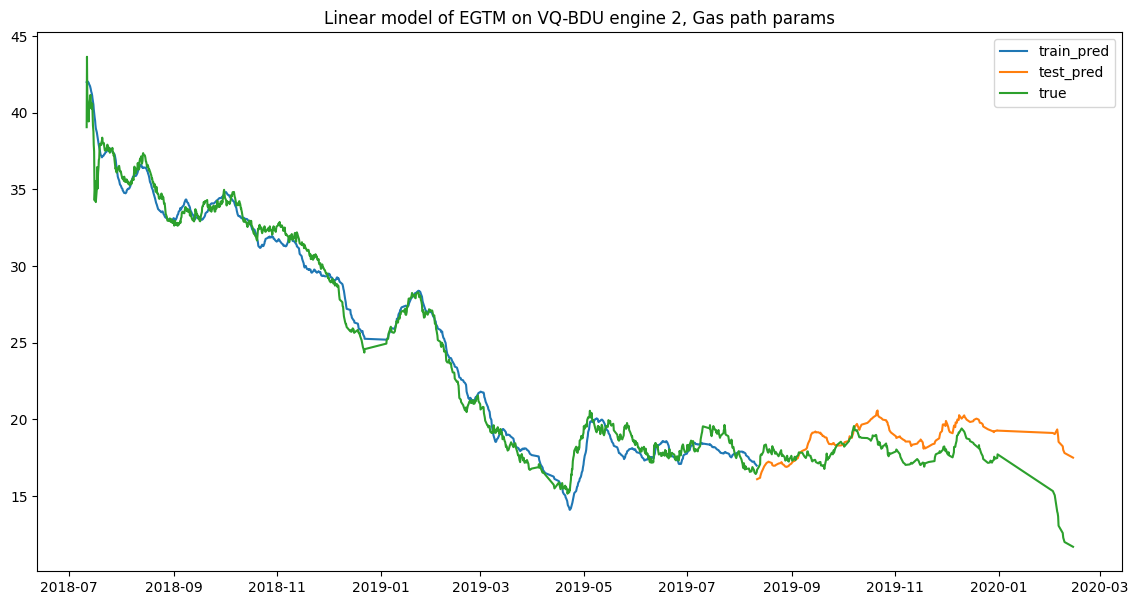

In [6]:
plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test['pred'], predicted_train['pred'], is_smooth=True)

In [7]:
features_k = ['egtk', 'tat', 'oat', 'n1ak', 'n2ak', 'wai', 'nai', 'prv', 'alt', 'mn', 'ffk', 'nfk']

data = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features_k,
  n_back=20,
)

X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_boolean_ensemble_model(X, y, field='prv')

print(f'PRV ensemble: {metrics}')


PRV ensemble: {'rmse': 1.60464, 'mae': 1.32035, 'r2': 0.53882, 'mape': 0.065}


In [8]:

def predict_num_ensemble(models: List[LinearRegression], X: pd.DataFrame, field: str='alt', bins: List[List[float]]=[]):
  pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
  for i, [bottom, top] in enumerate(bins):
    index = (X[field] > bottom) & (X[field] <= top)
    pred.loc[index, 'pred'] = models[i].predict(X[index])
  return pred

def filter_split_by_num_field(X: pd.DataFrame, y: pd.DataFrame, field: str, bin: List[float]):
  bottom, top = bin
  index = (X[field] > bottom) & (X[field] <= top)
  return X[index], y[index]

def train_numeric_ensemble_model(X, y, model = 'linreg', field: str='alt', bins: List[List[str]]=[]):
  assert len(X) == len(y)

  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  ensemble = {i: LinearRegression() for i in range(len(bins)) }

  assert len(ensemble) == len(bins)

  for i, bin in enumerate(bins):
    X_train_f, y_train_f = filter_split_by_num_field(X_train, y_train, field, bin)
    ensemble[i].fit(X_train_f, y_train_f)
  
  predicted_train = predict_num_ensemble(ensemble, X_train, field, bins)
  predicted_test = predict_num_ensemble(ensemble, X_test, field, bins)

  return get_metrics(y_test, predicted_test), model, predicted_train, predicted_test, train_i, y_test

In [9]:
features_k = ['egtk', 'tat', 'oat', 'n1ak', 'n2ak', 'wai', 'nai', 'prv', 'alt', 'mn', 'ffk', 'nfk']

data = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features_k,
  n_back=20,
)

X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test =  \
  train_numeric_ensemble_model(
    X, y, 'alt', 
    bins=[[0, 3000], [3000, 10_000]]
  )

print(f'Altitude ensemble: {metrics}')

Altitude ensemble: {'rmse': 1.61621, 'mae': 1.31916, 'r2': 0.53214, 'mape': 0.06483}


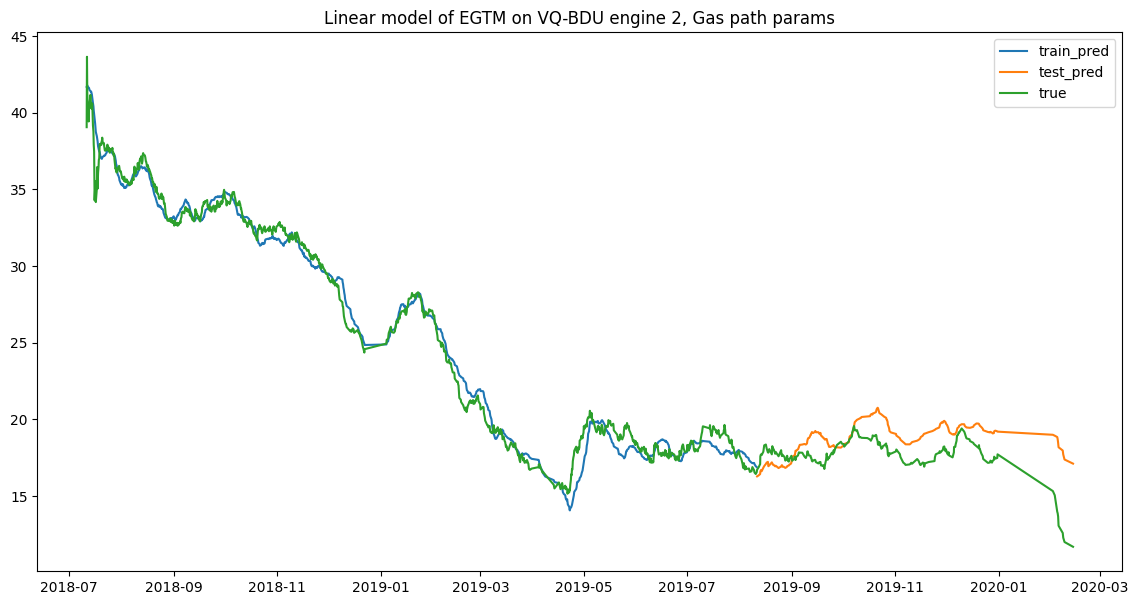

In [10]:
plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test['pred'], predicted_train['pred'], is_smooth=True)

Попробовать использовать только EGTK: 

In [11]:
features_k = ['egtk', 'n1ak', 'alt']

data = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features_k,
  n_back=20,
)

X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test =  \
  train_numeric_ensemble_model(
    X, y, 'alt', 
    bins=[[0, 3000], [3000, 10_000]]
  )

print(f'Altitude ensemble: {metrics}')

Altitude ensemble: {'rmse': 4.03449, 'mae': 3.27231, 'r2': -1.91539, 'mape': 0.16081}


In [12]:
# plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test['pred'], predicted_train['pred'], is_smooth=True)